In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn import metrics, model_selection
from sklearn.cross_validation import cross_val_score
from scipy import stats
import xgboost as xgb
from sklearn.linear_model import Lasso, LassoCV, Ridge

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_columns', 500)

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv('input/train_custom_2.csv', index_col=0)
test = pd.read_csv('input/test_custom_2.csv',index_col=0)

In [3]:
def rmse(y_true, y_pred):
    return np.sqrt(metrics.mean_squared_error(y_true, y_pred))

def rmse_cv(model, x, y):
    return np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv = 5))

rmse_scorer = metrics.make_scorer(rmse, greater_is_better=False)

In [4]:
y = df['SalePrice']
df.drop('SalePrice',1,inplace=True)

## Linear Regression (Ridge)

In [6]:
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
cv_ridge = [rmse_cv(Ridge(alpha = alpha, max_iter=50000), df, y).mean() for alpha in alphas]

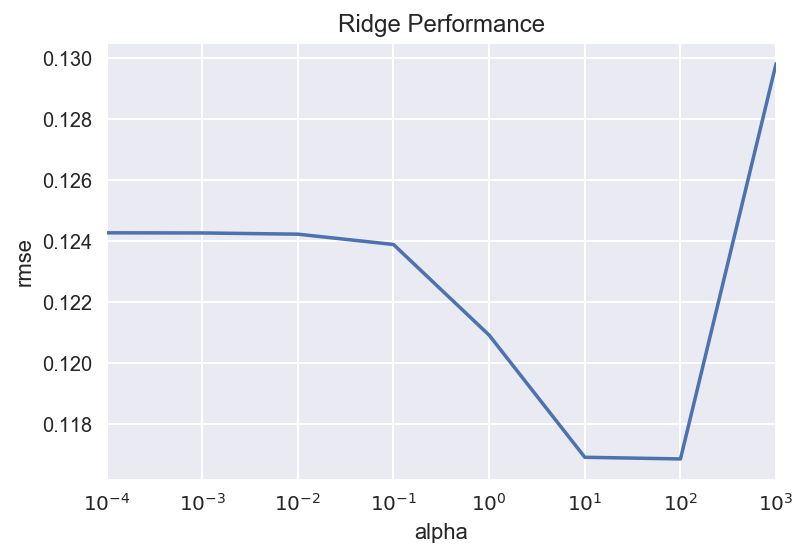

In [8]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Ridge Performance")
plt.xlabel("alpha")
plt.ylabel("rmse")
ax = plt.gca()
ax.set_xscale('log')

In [9]:
# Best Ridge RMSE
cv_ridge.min()

0.11683627008017575

In [18]:
model_ridge = Ridge(alpha=10, max_iter=50000)
model_ridge.fit(df, y)

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=50000,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [19]:
# Run prediction on the Kaggle test set.
y_pred_ridge = model_ridge.predict(test)

## Linear Regression (LASSO)

In [10]:
alphas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,110,125,150,175,200]
model_lasso = LassoCV(alphas = alphas, cv=10, max_iter=50000).fit(df, y)
# Best Lasso RMSE
rmse_cv(model_lasso,df,y).mean()

/usr/local/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.11496085130114431

In [11]:
model_lasso.alpha_

0.001

In [22]:
param_grid = {'alpha': alphas}
lasso = Lasso(max_iter=50000)
lasso_gs = model_selection.GridSearchCV(lasso, param_grid, cv=10,scoring=rmse_scorer)
lasso_gs.fit(df, y)
print(lasso_gs.best_score_)
print(lasso_gs.best_params_)
#0.113569824533
#1131

-0.11394641571
{'alpha': 0.001}


In [328]:
coef = pd.Series(model_lasso.coef_, index = test.columns)

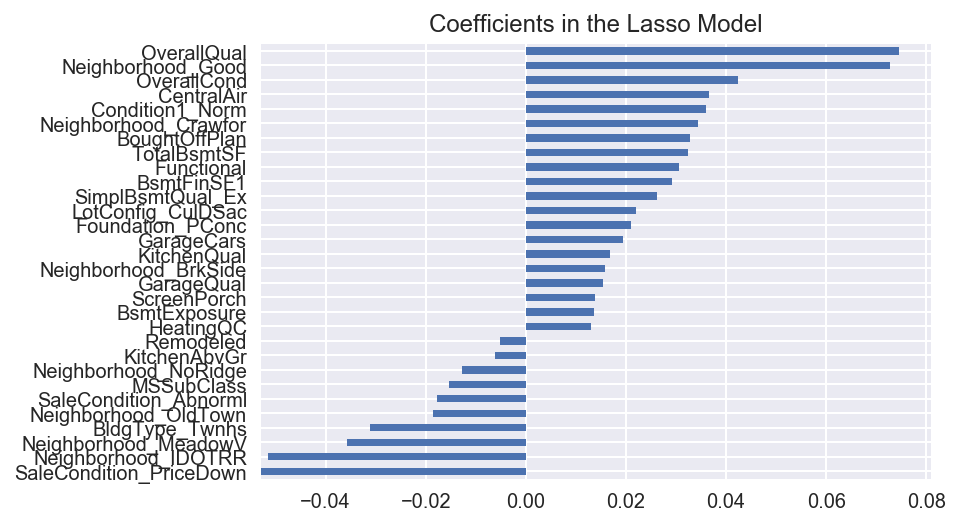

In [329]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(20)])
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

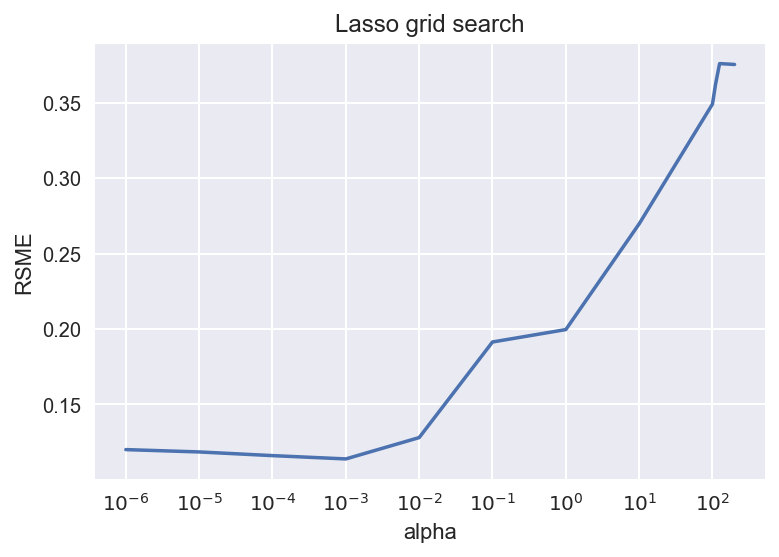

In [330]:
plt.plot([item['alpha'] for item in lasso_gs.cv_results_['params']], 
         [-item for item in lasso_gs.cv_results_['mean_test_score']])
plt.xlabel('alpha')
plt.ylabel('RSME')
plt.title('Lasso grid search')
ax = plt.gca()
ax.set_xscale('log')

In [331]:
# Check how many coefficients become zero
#coef = lasso_gs.best_estimator_.coef_
#not_zero_indices = np.where(coef!=0)

# Display most important features
#large_indices = coef
#plt.barh(range(len(coef)), coef)
#plt.yticks(range(len(coef)), df.columns)
#plt.title('Most imporant features')

In [12]:
#regr = Lasso(alpha=lasso_gs.best_params_['alpha'])
model_lasso.fit(df, y)

LassoCV(alphas=[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 110, 125, 150, 175, 200],
    copy_X=True, cv=10, eps=0.001, fit_intercept=True, max_iter=50000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [13]:
# Run prediction on the Kaggle test set.
y_pred_lasso = model_lasso.predict(test)

# XGBoost

In [42]:
model_xbg = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 learning_rate=0.01,
                 max_depth=6,
                 gamma=0.0,
                 min_child_weight=9,
                 n_estimators=7000,  
                 subsample=0.6,
                 seed=42)

#rmse_cv(model_xbg, df, y).mean()
#0.11383767477118911

In [43]:
model_xbg.fit(df, y)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.2,
       gamma=0.0, learning_rate=0.01, max_delta_step=0, max_depth=6,
       min_child_weight=8, missing=None, n_estimators=6800, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=42, silent=True, subsample=0.6)

In [44]:
# Run prediction on the Kaggle test set.
y_pred_xgb = model_xbg.predict(test)

In [45]:
y_pred = (y_pred_lasso + y_pred_xgb) / 2
#y_pred = y_pred_lasso
y_pred = np.expm1(y_pred)

pred_df = pd.DataFrame(y_pred, index=test.index, columns=["SalePrice"])
pred_df.to_csv('output_ensemble.csv', header=True, index_label='Id')